<a href="https://colab.research.google.com/github/josephg99/hello-world/blob/main/Assignment_1_Use_regression_models_to_predict_bus_arrival_delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Use regression models to predict bus arrival delays

Assignment task: Use regression models to predict bus arrival delays.

You have learned and practiced the general process of building and training regression-based machine learning models in Python, and practical techniques of feature normalization, hyperparameter tuning using grid search, training/testing split, and cross validation.

In this assignment, you will follow the practice exercise and develop xGBoost models to predict bus arrival delays and tune the model parameters to achieve the best performance. Once you are done with the task,

Upload your code on your own Github repository
Make a post in the discussion forum below, where you
Share your Github code link in the post
Describe your model structure (i.e., inputs, outputs) and training settings (e.g., objective function, training/testing split, etc.)
Report your best xGBoost model parameters and the testing performance (e.g., RMSE)
Reflect on the lessons you learned from the exercise, and also any other transportation problems that you may envision using the learned techniques  
The post should be around 150-200 words and include references (as always) wherever it is necessary.

After you posted your text, read and give feedback in a reply to at least 2 other main posts before the due date. Choose the ones that have less than 2 replies so that everybody (or as many as possible) will get peer feedback.

Checklist before you submit your text:

The text is around 150-200 words
I have used the headings as specified above
I have referred to online materials and included a reference section (Note: that section is outside of the word limit)
Please observe: the discussion forum is configured to not show you any posts before you have made your post. After that, you will be able to read what the fellow course participants have posted.

# Part 1 - Load in the Data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv'
df = pd.read_csv(url)

df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [3]:
#optional_url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2optional.csv'
#df_optional = pd.read_csv(optional_url)

In [4]:
df.info() # shows data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


In [5]:
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1) # drop columns

In [6]:
corr_matrix = df.corr() # correlation matrix
corr_matrix['Arrival_delay'].sort_values(ascending=False)

,Arrival_delay
Arrival_delay,1.000000
Upstream_stop_delay,0.993935
Dwell_time,0.218745
Recurrent_delay,0.162692
Scheduled_travel_time,0.100695


In [7]:
df = df.drop(['Scheduled_travel_time'], axis=1) # drop columns
df

,Arrival_delay,Dwell_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,-4,28.641509
1,168,0,181,27.880597
2,231,0,244,27.852941
3,150,17,143,27.826087
4,965,35,947,42.029412
...,...,...,...,...
2174,123,10,128,34.189873
2175,78,0,95,34.197531
2176,86,23,82,35.414634
2177,121,10,119,35.373494


I chose to remove the Scheduled travel time since I do not see how that would affect the arrival delay, maybe depending on time of day but still due to the low correlation value too I choose to just focus on the upstream stop delay, dwell time and recurrent delay.

My reason is also to minimize overfitting of the model. I do not want to include all the parameters just because they are available.

<Axes: xlabel='Arrival_delay', ylabel='Count'>

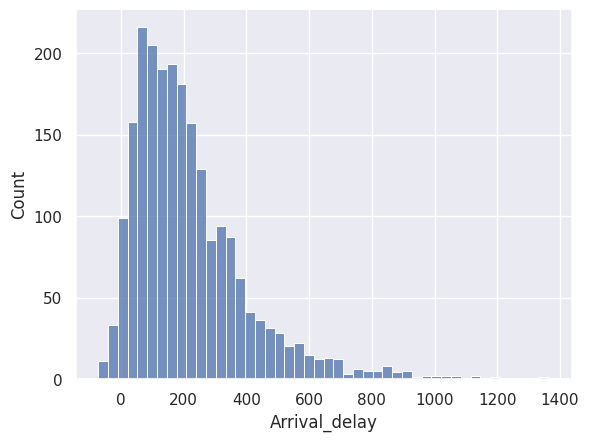

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.histplot(x=df['Arrival_delay'])

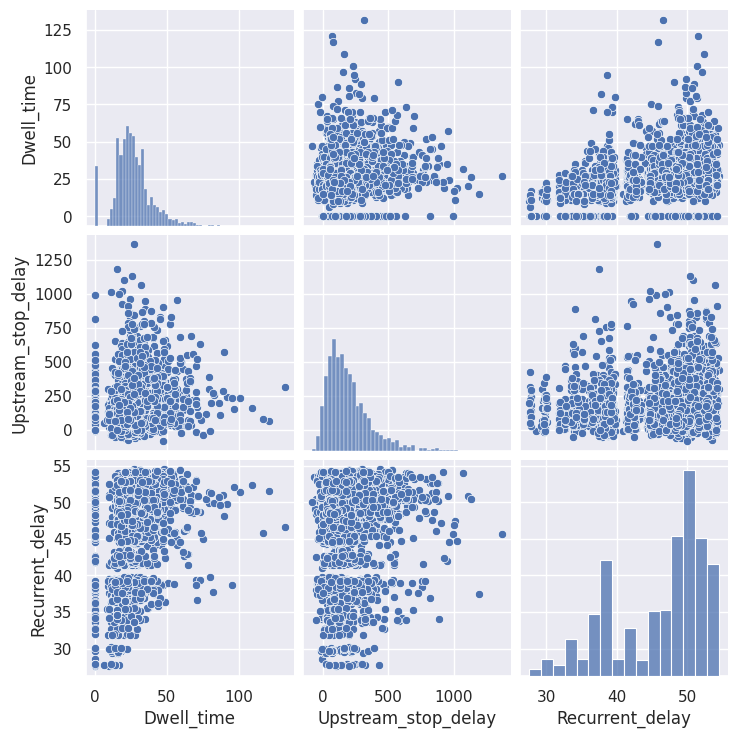

In [9]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x) # pairplot

# Part 2 - Train Regression Model

Normalisation is not needed for the XGB boost model i will be using. And the data is in seconds and doesn't use distance

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [11]:
df

,Arrival_delay,Dwell_time,Upstream_stop_delay,Recurrent_delay
0,-23,0,-4,28.641509
1,168,0,181,27.880597
2,231,0,244,27.852941
3,150,17,143,27.826087
4,965,35,947,42.029412
...,...,...,...,...
2174,123,10,128,34.189873
2175,78,0,95,34.197531
2176,86,23,82,35.414634
2177,121,10,119,35.373494


# XGBREGRESSOR MODEL

In [12]:
#XGB BOOST MODEL

from xgboost import XGBRegressor

model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 11.947446025566224
Mean Squared Error: 270.26353661397746
R-squared: 0.9909368239094506


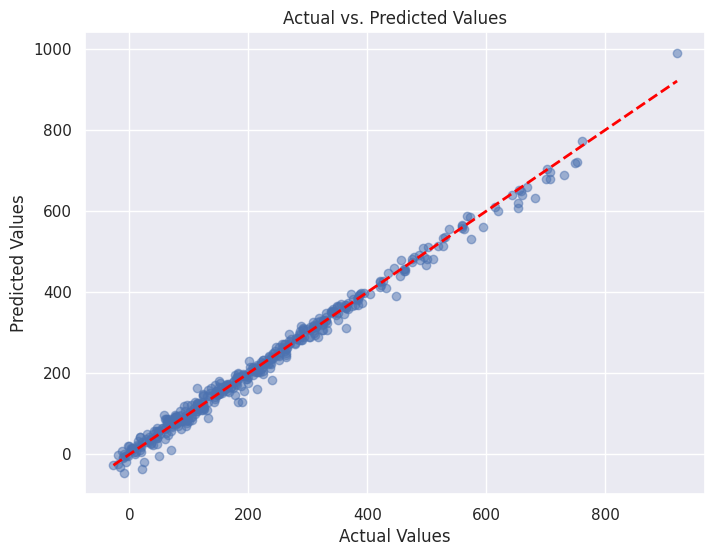

In [14]:
import matplotlib.pyplot as plt

# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

I deicde to use Gridsearch on the XGBoost model to improve it.

In [15]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the GridSearchCV object with XGBRegressor
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=2, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END 

In [16]:
# Create an XGB model with the best parameters from the grid search
best_XGB = XGBRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'])
# Train the model on the training data
best_XGB.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_XGB.predict(X_test)

# Perform cross-validation on the training data (recommended)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_XGB, X_train, y_train, cv=5, verbose=2).mean()
print(f"Average Cross-Validation Score: {cv_scores}")

[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
Average Cross-Validation Score: 0.9914850320315521


In [17]:
best_XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = grid_search.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 10.838441460504445
Mean Squared Error: 217.34408139881907
R-squared: 0.9927114559861261


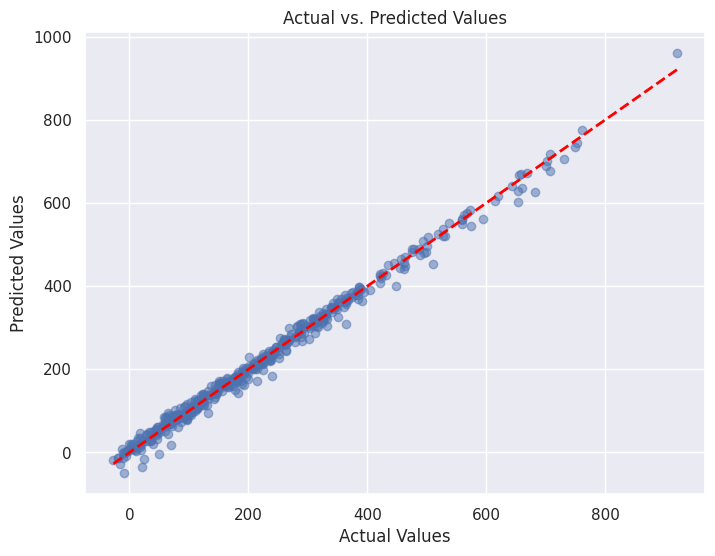

In [19]:
# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

After making the Hyperparameter test, I can see that the model became better, even though it was really well made from the beginning. But still better R values in the model with grid search.

# EXPLANATION

**Assignment 1 Explanation:**
To predict delay, I chose Upstream_stop_delay, Dwell_time, and Recurrent_delay as the input features. I decided to remove Scheduled_travel_time because it had a very low correlation with the arrival delay. Removing this parameter also helps to minimize the risk of overfitting.

I then split the data into training and testing sets to build the XGBoost model.

After testing different hyperparameters, I found the best combination to be:

colsample_bytree: 0.8
learning_rate: 0.1
max_depth: 2
n_estimators: 200
subsample: 1.0

The initial R-squared value was strong, and tuning the hyperparameters with grid search further improved the model's performance.